In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)

2024-05-29 18:56:08.879405: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 18:56:08.900290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 18:56:09.343096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mmgsilva (mmgsilvawb). Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(
    dir = "../results/syntheticdata/",
    project = "indexes_subsequence_lstm"
)

In [4]:
#create synthetic time series random uniform integers
n = 1000
data = np.random.randint(1, 6, n)

#select random timewindows of length 5 without overlapping
motif_indexes = []
motif_pattern = [1,1,1,1,1]
p = len(motif_pattern)

max_interval = n//10
print("Max interval between motif", max_interval)
last_index = 0
while True:
    index_interval = np.random.randint(p+4, p + max_interval)
    if last_index + index_interval + p > n:
        break
    last_index = last_index + index_interval
    motif_indexes.append(last_index)

print("Planted motifs:", len(motif_indexes))
motif_indexes

Max interval between motif 100
Planted motifs: 18


[51,
 107,
 147,
 176,
 246,
 328,
 348,
 425,
 522,
 583,
 596,
 643,
 674,
 742,
 767,
 829,
 909,
 981]

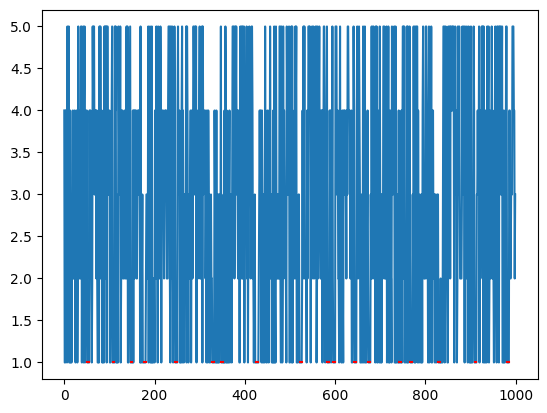

In [5]:
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes:
    data[idx:idx+p] = motif_pattern

#introduce clue in the data
for idx in motif_indexes:
    data[idx-5:idx-2] = [1,2,3]

#plot the data and in red the motif pattern
plt.plot(data)
for idx in motif_indexes:
    plt.plot(range(idx, idx+p), motif_pattern, 'r')

In [6]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data, past_window, step, forward_window, motif_indexes):
    X1, X2, y1, y = list(), list(), list(), list()
    for idx in range(len(data) - past_window - 1):
        if idx % step != 0:
            continue
    
        next_matches = [motif_idx for motif_idx in motif_indexes if motif_idx > idx + past_window]
        if not next_matches:
            continue #no match
        next_match = next_matches[0]
        if next_match > idx + past_window + forward_window:
            next_match = -1 #no match in forward window

        data_x1 = data[idx:idx+past_window]
        data_x2 = [motif_idx for motif_idx in motif_indexes if motif_idx <= idx+past_window]
        data_y1 = data[idx+past_window]
        data_y = next_match
        X1.append(data_x1)
        X2.append(data_x2)
        y1.append(data_y1)
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2), np.array(y1), np.array(y)

In [7]:
past_window = 100 #window size
step = 1 #step size for the sliding window
forward_window = 50 #
X1, X2, y1, y  = create_dataset(data, past_window=past_window, step=step, forward_window=forward_window, motif_indexes=motif_indexes)
print(X1[0], X2[0], y1[0], y[0])

[4 1 1 4 2 4 1 5 3 4 5 1 1 4 1 3 1 3 3 4 2 3 2 4 2 1 3 4 3 1 2 5 3 2 3 4 2
 5 5 1 3 4 5 1 4 5 1 2 3 4 4 1 1 1 1 1 4 2 4 3 2 1 2 5 4 5 5 3 4 3 4 2 4 2
 1 1 2 1 5 2 5 3 2 4 1 3 1 1 1 5 2 5 4 5 1 5 5 3 3 3] [51 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 4 107


In [8]:
#reshape input to be [samples, time steps, features]
X1 = np.reshape(X1, (X1.shape[0],  X1.shape[1], 1))
X2 = np.reshape(X2, (X2.shape[0],  X2.shape[1], 1))
X1.shape, X2.shape, y1.shape, y.shape

((881, 100, 1), (881, 17, 1), (881,), (881,))

In [9]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [10]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(X2.shape[1], X2.shape[2])))
        model.add(Masking(mask_value=-1))
        units = hp.Int('units', min_value=10, max_value=50, step=10)
        model.add(LSTM(units=units, activation='relu', return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model


In [11]:
import collections
from keras.callbacks import EarlyStopping
import pickle

# cols are metrics
# which are val_loss, val_mae, val_rmse, val_r2
metrics_history = []

class CVTuner(kt.engine.tuner.Tuner):

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss"))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[2,8,16,32,64])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)
        for i, (train_indices, test_indices) in enumerate(cv.split(x)):
            #split train indices into train and validation
            mid = int(0.8 * len(train_indices))
            train_indices, val_indices = train_indices[:mid], train_indices[mid:]
            X_train, X_val, X_test = x[train_indices], x[val_indices], x[test_indices]
            y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)
            #save metrics
            for j, (_, value) in enumerate(metrics.items()):
                trial_metrics[i, j] = value[-1]

        metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)

tuner = CVTuner(
  hypermodel=MyHyperModel(),
  oracle=kt.oracles.GridSearchOracle(
    objective=kt.Objective("test_loss", "min"),
    max_trials=None),
    directory='../results/syntheticdata',
    project_name='indexes_subsequence_lstm')

# each fold 139 train 35 test
tuner.search(
        x=X2,
        y=y,
        verbose=0,
        callbacks=[WandbMetricsLogger(log_freq=5)],
    )
run.finish()

# aggregate metric_history into a matrix (num trials, num folds, num metrics)
metrics_history = np.array(metrics_history)

# save metrics_history
fname = os.path.join(tuner.directory, "metrics_history.npy")
np.save(fname, metrics_history)

2024-05-29 18:56:14.083963: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 18:56:14.084135: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-29 18:56:14.649456: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
wandb: ERROR Unable to log learning rate.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29619.1797 - mae: 170.2538 - r2_score: -2.3936 - root_mean_squared_error: 172.1013  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46925.9727 - mae: 111.6625 - r2_score: -0.3431 - root_mean_squared_error: 216.5390  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17823.2266 - mae: 133.3955 - r2_score: -78.0575 - root_mean_squared_error: 133.5036  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 460727.1250 - mae: 562.9418 - r2_score: -2.0918 - root_mean_squared_error: 678.7091  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87782.0703 - mae: 296.2804 - r2_score: 0.0000e+00 - root_mean_squared_error: 296.2804  
{'test_loss': 129952.132421875, 'test_mae': 256.2064666748047, 'test_rmse': 299.9364715576172, 'test_r2': -17.166444087028502}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42932.3594 - mae: 206.8436 - r2_score: -3.9181 - root_mean_squared_error: 207.2010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110005.9453 - mae: 326.4946 - r2_score: -2.15

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/loss,▁▁▁▁█▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂
batch/mae,▁▂▂▁█▃▂▃▁▂▁▂▄▁▂▁▁▁▂▂▃▂▂▃▁▂▁▁▂▁▃▂▁▂▁▂▃▂▂▃
batch/r2_score,████▁▇▇▇▇▇▇█▇▇▇██████▇▇██████▇▇▇████▆▇██
batch/root_mean_squared_error,▁▂▁▁█▃▂▃▁▂▁▁▄▁▂▂▁▂▃▂▃▂▂▃▁▂▁▁▂▁▃▂▁▂▂▂▃▂▃▃
epoch/epoch,▄▇▄▁▅▂▇▄█▄▁▅▂▇▄▁▅▂▇▄▁▅▂▇▂▇▅▂▇▄▁▅▂▇▄▁▅▂▇▄
epoch/loss,▂▂▃▃▃▂▂▂▁▁▁█▅▃▇▂▁▂▂▂▂▁▁▄▃▂▂▂▁▂▂▁▁▂▃▄▄▃▂▃
epoch/mae,▃▃▅▅▅▄▃▃▁▂▂█▆▅▇▃▂▃▃▃▃▂▂▅▄▂▄▃▃▃▃▂▂▄▅▅▆▅▄▅
epoch/r2_score,▇█▆▆▅▆▆▅█▅▅▅▇▅▁▇█▇▆▆▆▆▆▇██▆▇▇▆▆▅▇█▇▇▄▆▆▅
epoch/root_mean_squared_error,▃▃▅▅▅▄▃▃▁▂▂█▆▅▇▃▂▃▃▃▃▂▂▅▄▃▄▃▃▃▃▂▁▄▅▆▆▅▄▅
epoch/val_loss,▁▃▂▂▃▂▂▁▁▁▁▄▃▃█▁▁▁▂▂▂▁▁▂▂▁▂▂▁▂▂▁▁▂▂▂▃▂▂▃


In [12]:
metrics_history[0].mean(axis=0)

array([ 1.2995214e+05,  2.5620648e+02,  2.9993646e+02, -1.7166445e+01],
      dtype=float32)

In [13]:
tuner.results_summary()

Results summary
Results in ../results/syntheticdata/indexes_subsequence_lstm
Showing 10 best trials
Objective(name="test_loss", direction="min")

Trial 0001 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 8
Score: 86887.98251953124

Trial 0061 summary
Hyperparameters:
units: 50
learning_rate: 0.001
batch_size: 8
Score: 91350.015234375

Trial 0062 summary
Hyperparameters:
units: 50
learning_rate: 0.001
batch_size: 16
Score: 97887.1392578125

Trial 0016 summary
Hyperparameters:
units: 20
learning_rate: 0.001
batch_size: 8
Score: 99826.29140625

Trial 0031 summary
Hyperparameters:
units: 30
learning_rate: 0.001
batch_size: 8
Score: 104194.8025390625

Trial 0046 summary
Hyperparameters:
units: 40
learning_rate: 0.001
batch_size: 8
Score: 106759.3546875

Trial 0050 summary
Hyperparameters:
units: 40
learning_rate: 0.0001
batch_size: 2
Score: 117298.55053710938

Trial 0000 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 2
Score: 129952.132421875

Trial

In [9]:
#get config of the best model
best_trial = tuner.oracle.get_best_trials(1)[0]

print(best_trial.metrics.get_best_value("test_mae"))
print(metrics_history[int(tuner.oracle.get_best_trials(1)[0].trial_id)].mean(axis=0))

#train the best model, using the best hyperparameters
cv = BlockingTimeSeriesSplit(5)
metrics = []

for i, (train_indices, test_indices) in enumerate(cv.split(X2)):
    mid = int(0.8 * len(train_indices))
    train_indices, val_indices = train_indices[:mid], train_indices[mid:]
    X_train, X_val, X_test = X2[train_indices], X2[val_indices], X2[test_indices]
    y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
    model = MyHyperModel().build((best_trial.hyperparameters))
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=best_trial.hyperparameters.get("batch_size"), verbose=0, callbacks=EarlyStopping(patience=10, monitor="val_loss"))
    test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test)
    metrics.append([test_loss, test_mae, test_rmse, test_r2])

metrics = np.array(metrics)
metrics.mean(axis=0)

NameError: name 'tuner' is not defined

In [ ]:
def create_model_embeddinglstm(hp):
    model = Sequential()
    model.add(LSTM(units=50, activation='tanh', return_sequences=False))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

import keras_tuner as kt
from keras.callbacks import EarlyStopping

tuner= kt.RandomSearch(
        create_model_embeddinglstm,
        objective='mae',
        max_trials=5,
        executions_per_trial=3,
        project_name = 'embeddinglstm'
        )

tuner.search(
        x=X1,
        y=y1,
        epochs=10,
        batch_size=64
        )


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y1_train_pred = best_model.predict(X1_train)
mse = mean_squared_error(y1_train, y1_train_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y1_train, y1_train_pred)
r2 = r2_score(y1_train, y1_train_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y1_train, label='True')
plt.plot(y1_train_pred, label='Predicted')



In [ ]:
#get the embedding layer
embeddings = best_model.layers[1].get_weights()[0]
#embeddings to 1d array
embeddings = embeddings.flatten()
embeddings

In [ ]:
#join the embeddings with the motif indexes
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape


In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

In [ ]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_train, label='True')
plt.plot(y_train_pred, label='Predicted')

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')


In [ ]:
#join the embeddings with the motif indexes and the motif pattern
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape
